In [1]:
using ChaosTools
using DynamicalSystems
using PyPlot
using OrdinaryDiffEq, LinearAlgebra, ForwardDiff, PyPlot
using Distributions

In [18]:
PyPlot.pygui(false)

false

In [2]:

x = rand(Truncated(Normal(0, 1.), -1., 1.), 100)
x=x.-8
y=rand(Truncated(Normal(0, 1.), -1.5, 1.5), 100)
grid=Iterators.product(x,y)
grid=collect.(grid)
println(grid[1])
println(grid[1][1])
#pre(grid[1][1],grid[1][2],m[1],m[2],a,b,Hinicial)

[-7.866904801052444, -0.4270921971915876]
-7.866904801052444


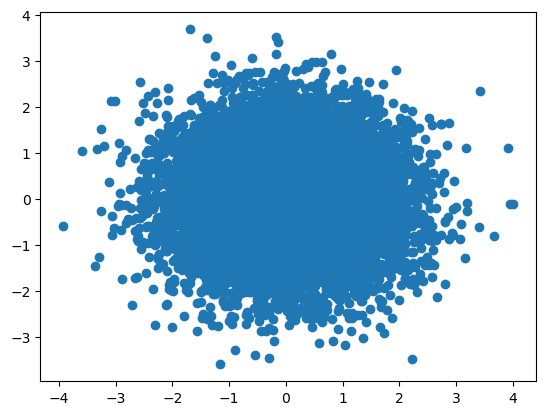

  0.000023 seconds (6 allocations: 78.359 KiB)
  0.000021 seconds (6 allocations: 78.359 KiB)
  0.000341 seconds (23 allocations: 313.180 KiB)
  0.000404 seconds (23 allocations: 313.180 KiB)


10000-element Array{Float64,1}:
 -1.0459630539858813
 -1.1016412841002878
 -1.2497477158993662
 -1.3325803068949755
 -1.0686679843577345
 -1.0577758517706626
 -1.2795258059163337
 -1.342054130294546 
 -1.3238852705674258
 -1.3025142302106882
 -1.23244959607413  
 -1.1873815055029147
 -1.196790178524942 
  ⋮                 
 -1.2675624461000046
 -1.2236983397775458
 -0.9849085496194661
 -1.0649704470808714
 -1.0819042989402299
 -1.3294564425659576
 -1.2492059198232375
 -1.1305904302639087
 -1.2380307985990258
 -1.31262777254573  
 -1.3048635279968324
 -1.1304011663751428

In [6]:
arraysize=10000
@time u1 = rand(arraysize)
@time u2 = rand(arraysize)
@time z0 = map.(sqrt,-2* map.(log,u1)) .*map.(cos,2. *pi*u2)
@time z1 = map.(sqrt,-2* map.(log,u1)) .*map.(sin,2. *pi*u2)
scatter(z0,z1)

xz0=z0*0.15
pz1=z1*0.1
Xz0=z0 .-17.2
Pz1=z1*0.1 .-1.2

#x=x.-8
#y=rand(Truncated(Normal(0, 1.), -1.5, 1.5), 100)
#grid=Iterators.product(x,y)
#grid=collect.(grid)
#println(grid[1])
#println(grid[1][1])

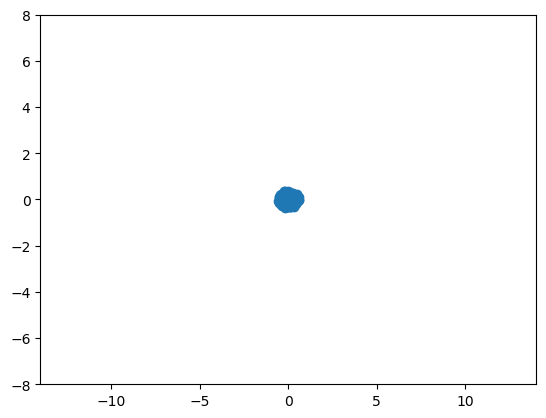

(-14, 14)

In [7]:
scatter(xz0,pz1)
ylim(-8,8)
xlim(-14,14)


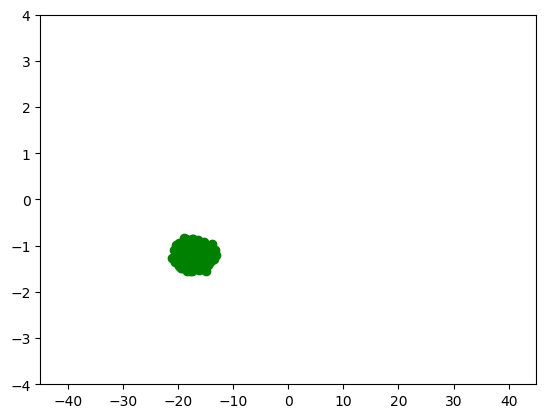

(-45, 45)

In [8]:
scatter(Xz0,Pz1,color="g")
ylim(-4,4)
xlim(-45,45)

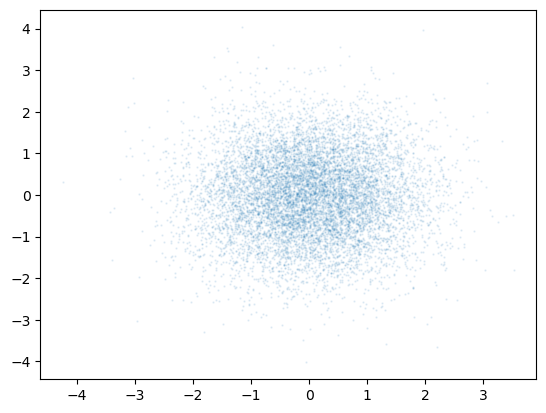

  0.177388 seconds (174.54 k allocations: 8.984 MiB)


PyObject <matplotlib.collections.PathCollection object at 0x14f35d590>

In [6]:
@time scatter(z0,z1,alpha=0.1,s=0.5)

In [11]:
initial_position = [0.1, 0.]
initial_momentum=[0. ,0.1]

2-element Array{Float64,1}:
 0.0
 0.1

In [21]:
function energia_poinc_abs(x0, p0, m0, M0, a0, b0, H0)
    return (2. *M0*(H0-p0*p0/(2. *m0)+a*x0*x0/2. -b*x0*x0*x0*x0/4. ))^(1. /2. )
end
epsilon=0.01
m=[1.,0.1]
w=[0.,0.8]
g=[0.,0.1]
a=0.25
b=0.01
entmutua=[]
entsys=[]
entpozo=[]
entosci=[]
time=100.
dts=1//100
entropies=zeros(100)
Q1=[]
Q2=[]
P1=[]
P2=[]
tspan=(0., time)
k=0
sol3=0

m[2]=0.1
w[2]=0.7071
g[2]=0.05
dts=0.001*2. *pi/w[2]
Hsys(q,p) = p[1]^2. /(2. *m[1]) - a*q[1]^2. /2. +b*q[1]^4. /4. +q[1]*g[2]*q[2]+p[2]^2. /(2. *m[2])+m[2]*w[2]^2. *q[2]^2. /2. 
pdot(dp,p,q,params,t) = ForwardDiff.gradient!(dp, q->-Hsys(q, p), q)
qdot(dq,p,q,params,t) = ForwardDiff.gradient!(dq, p-> Hsys(q, p), p)
initial_position[2]=0.

@time for jj =1:10000
    #println(jj)
    Hinicial=15.0
    initial_position[1]=grid[jj][1]
    initial_momentum[1]=grid[jj][2]
    
    initial_momentum[2]=energia_poinc_abs(initial_position[1],initial_momentum[1],m[1],m[2],a,b,Hinicial) #osciladores
    prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
    sol3 = solve(prob, CalvoSanz4(), dt=dts);
    #@time sol3 = solve(prob, CalvoSanz4(), dt=dts);
    push!(Q1,sol3[3,1:10:end])
    push!(Q2,sol3[4,1:10:end])
    push!(P1,sol3[1,1:10:end])
    push!(P2,sol3[2,1:10:end])
    k=sol3
    

end
dim=length(Q2[1])
Q1=reduce(hcat,Q1)
Q2=reduce(hcat,Q2)
P1=reduce(hcat,P1)
P2=reduce(hcat,P2)
system=cat(Q1,Q2,P1,P2,dims=3)
pozo=cat(Q1,P1,dims=3)
oscilador=cat(Q2,P2,dims=3)
println(dim)
bbb=0
ccc=0

#draw()
@time for iiii in 1:dim
    num=lpad(iiii,8,"0")
    systemdata=Dataset(system[iiii,:,:])
    push!(entsys,genentropy(1, epsilon, systemdata;base=2.))
    pozodata=Dataset(pozo[iiii,:,:])
    if iiii==20
        bbb=pozodata
    end
    if iiii%5==0
        PyPlot.scatter(pozodata[:,1],pozodata[:,2], alpha=0.4, s=1.5)
        ylim(-6,6)
        xlim(-11,11)
        xlabel("x")
        ylabel("p")
        title("Espacio de fase del pozo")
        savefig("gifs/pozo$num.png")
        clf()
    end


    push!(entpozo,genentropy(1, epsilon, pozodata;base=2.))
    oscidata=Dataset(oscilador[iiii,:,:])
    if iiii==20
        ccc=oscidata
    end
    if iiii%5==0
        PyPlot.scatter(oscidata[:,1],oscidata[:,2], alpha=0.4, s=1.5)
        ylim(-2.5,2.5)
        xlim(-35,35)
        xlabel("x")
        ylabel("p")
        title("Espacio de fase del oscilador")
        savefig("gifs/osci$num.png")
        clf()
    end
    push!(entosci,genentropy(1, epsilon, oscidata;base=2.))
    push!(entmutua,entpozo[iiii]+entosci[iiii]-entsys[iiii])
end
#waitforbuttonpress()
#println(entsys)
#println(entpozo)
#println(entosci)
#println(entmutua)

BoundsError: BoundsError: attempt to access 70×70 Array{Array{Float64,1},2} at index [4901]

In [20]:
lim=1000
plot(entsys[1:400],label="system information")
plot(entpozo[1:400],label="particle information")
plot(entosci[1:400],label="oscillator information")
plot(entmutua[1:400],label="mutual information")
legend()
xlabel("time steps / 10")
ylabel("Shannon Information")
title("Mutual Information")
savefig("mutualinfo.png")
clf()

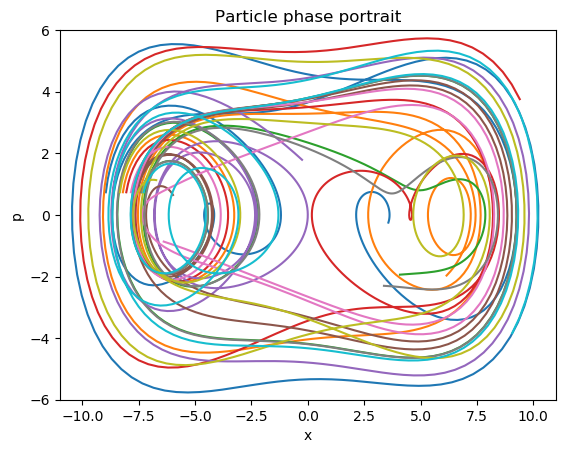

In [68]:
plot(Q1[1:400,1:10],P1[1:400,1:10])
title("Particle phase portrait")
xlabel("x")
ylabel("p")
ylim(-6,6)
xlim(-11,11)
savefig("mutualinfo_phase.png")
clf()

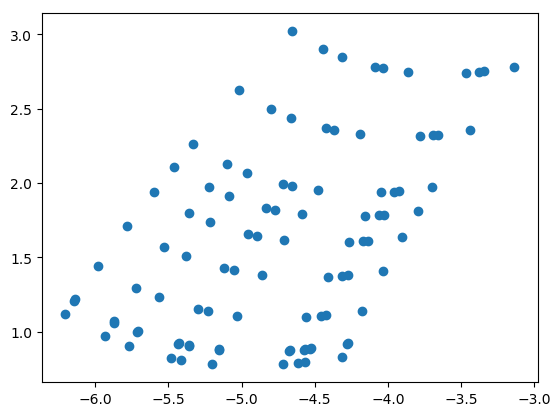

PyObject <matplotlib.collections.PathCollection object at 0x7f66095d7c50>

In [36]:
PyPlot.scatter(bbb[:,1],bbb[:,2])


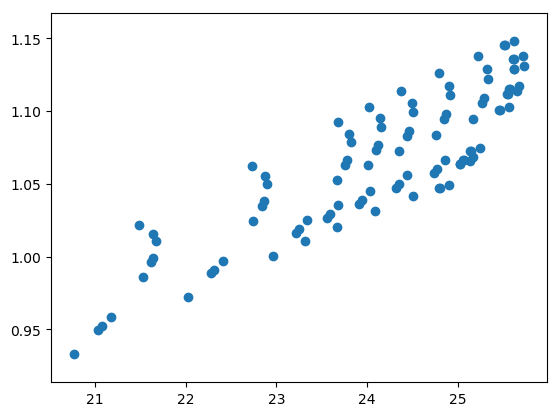

PyObject <matplotlib.collections.PathCollection object at 0x7f660805fe48>

In [62]:
PyPlot.scatter(ccc[:,1],ccc[:,2])

# Usando Box-Muller

In [14]:
function energia_poinc_abs(x0, p0, m0, M0, a0, b0, H0)
    return (2. *M0*(H0-p0*p0/(2. *m0)+a*x0*x0/2. -b*x0*x0*x0*x0/4. ))^(1. /2. )
end
epsilon=0.01
m=[1.,0.1]
w=[0.,0.8]
g=[0.,0.1]
a=0.25
b=0.01
entmutua=[]
entsys=[]
entpozo=[]
entosci=[]
time=100.
dts=1//100
entropies=zeros(100)
Q1=[]
Q2=[]
P1=[]
P2=[]
tspan=(0., time)
k=0
sol3=0

m[2]=0.1
w[2]=0.7071
g[2]=0.05
dts=0.001*2. *pi/w[2]
Hsys(q,p) = p[1]^2. /(2. *m[1]) - a*q[1]^2. /2. +b*q[1]^4. /4. +q[1]*g[2]*q[2]+p[2]^2. /(2. *m[2])+m[2]*w[2]^2. *q[2]^2. /2. 
pdot(dp,p,q,params,t) = ForwardDiff.gradient!(dp, q->-Hsys(q, p), q)
qdot(dq,p,q,params,t) = ForwardDiff.gradient!(dq, p-> Hsys(q, p), p)
initial_position[2]=0.

@time for jj =1:arraysize
    println(jj/arraysize)
    #Hinicial=15.0
    initial_position[1]=0. #xz0[jj]
    initial_momentum[1]=0. #pz1[jj]
    initial_position[2]=Xz0[jj]
    initial_momentum[2]=Pz1[jj]
    
    prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
    sol3 = solve(prob, CalvoSanz4(), dt=dts);
    #@time sol3 = solve(prob, CalvoSanz4(), dt=dts);
    push!(Q1,sol3[3,1:10:end])
    push!(Q2,sol3[4,1:10:end])
    push!(P1,sol3[1,1:10:end])
    push!(P2,sol3[2,1:10:end])
    k=sol3
    

end
dim=length(Q2[1])
Q1=reduce(hcat,Q1)
Q2=reduce(hcat,Q2)
P1=reduce(hcat,P1)
P2=reduce(hcat,P2)
system=cat(Q1,Q2,P1,P2,dims=3)
pozo=cat(Q1,P1,dims=3)
oscilador=cat(Q2,P2,dims=3)
println(dim)
bbb=0
ccc=0

#draw()
@time for iiii in 1:dim
    num=lpad(iiii,8,"0")
    systemdata=Dataset(system[iiii,:,:])
    push!(entsys,genentropy(1, epsilon, systemdata;base=2.))
    pozodata=Dataset(pozo[iiii,:,:])
    if iiii==20
        bbb=pozodata
    end
    if iiii%5==0
        PyPlot.scatter(pozodata[:,1],pozodata[:,2], alpha=0.4, s=1.2)
        ylim(-8,8)
        xlim(-14,14)
        xlabel("x")
        ylabel("p")
        title("Espacio de fase del pozo")
        savefig("gifs/boxmuller/pozo$num.png")
        clf()
    end


    push!(entpozo,genentropy(1, epsilon, pozodata;base=2.))
    oscidata=Dataset(oscilador[iiii,:,:])
    if iiii==20
        ccc=oscidata
    end
    if iiii%5==0
        PyPlot.scatter(oscidata[:,1],oscidata[:,2], alpha=0.4, s=1.2)
        ylim(-4,4)
        xlim(-45,45)
        xlabel("x")
        ylabel("p")
        title("Espacio de fase del oscilador")
        savefig("gifs/boxmuller/osci$num.png")
        clf()
    end
    push!(entosci,genentropy(1, epsilon, oscidata;base=2.))
    push!(entmutua,entpozo[iiii]+entosci[iiii]-entsys[iiii])
end
#waitforbuttonpress()
#println(entsys)
#println(entpozo)
#println(entosci)
#println(entmutua)

0.0001
0.0002
0.0003
0.0004
0.0005
0.0006
0.0007
0.0008
0.0009
0.001
0.0011
0.0012
0.0013
0.0014
0.0015
0.0016
0.0017
0.0018
0.0019
0.002
0.0021
0.0022
0.0023
0.0024
0.0025
0.0026
0.0027
0.0028
0.0029
0.003
0.0031
0.0032
0.0033
0.0034
0.0035
0.0036
0.0037
0.0038
0.0039
0.004
0.0041
0.0042
0.0043
0.0044
0.0045
0.0046
0.0047
0.0048
0.0049
0.005
0.0051
0.0052
0.0053
0.0054
0.0055
0.0056
0.0057
0.0058
0.0059
0.006
0.0061
0.0062
0.0063
0.0064
0.0065
0.0066
0.0067
0.0068
0.0069
0.007
0.0071
0.0072
0.0073
0.0074
0.0075
0.0076
0.0077
0.0078
0.0079
0.008
0.0081
0.0082
0.0083
0.0084
0.0085
0.0086
0.0087
0.0088
0.0089
0.009
0.0091
0.0092
0.0093
0.0094
0.0095
0.0096
0.0097
0.0098
0.0099
0.01
0.0101
0.0102
0.0103
0.0104
0.0105
0.0106
0.0107
0.0108
0.0109
0.011
0.0111
0.0112
0.0113
0.0114
0.0115
0.0116
0.0117
0.0118
0.0119
0.012
0.0121
0.0122
0.0123
0.0124
0.0125
0.0126
0.0127
0.0128
0.0129
0.013
0.0131
0.0132
0.0133
0.0134
0.0135
0.0136
0.0137
0.0138
0.0139
0.014
0.0141
0.0142
0.0143
0.0144
0.0145


0.119
0.1191
0.1192
0.1193
0.1194
0.1195
0.1196
0.1197
0.1198
0.1199
0.12
0.1201
0.1202
0.1203
0.1204
0.1205
0.1206
0.1207
0.1208
0.1209
0.121
0.1211
0.1212
0.1213
0.1214
0.1215
0.1216
0.1217
0.1218
0.1219
0.122
0.1221
0.1222
0.1223
0.1224
0.1225
0.1226
0.1227
0.1228
0.1229
0.123
0.1231
0.1232
0.1233
0.1234
0.1235
0.1236
0.1237
0.1238
0.1239
0.124
0.1241
0.1242
0.1243
0.1244
0.1245
0.1246
0.1247
0.1248
0.1249
0.125
0.1251
0.1252
0.1253
0.1254
0.1255
0.1256
0.1257
0.1258
0.1259
0.126
0.1261
0.1262
0.1263
0.1264
0.1265
0.1266
0.1267
0.1268
0.1269
0.127
0.1271
0.1272
0.1273
0.1274
0.1275
0.1276
0.1277
0.1278
0.1279
0.128
0.1281
0.1282
0.1283
0.1284
0.1285
0.1286
0.1287
0.1288
0.1289
0.129
0.1291
0.1292
0.1293
0.1294
0.1295
0.1296
0.1297
0.1298
0.1299
0.13
0.1301
0.1302
0.1303
0.1304
0.1305
0.1306
0.1307
0.1308
0.1309
0.131
0.1311
0.1312
0.1313
0.1314
0.1315
0.1316
0.1317
0.1318
0.1319
0.132
0.1321
0.1322
0.1323
0.1324
0.1325
0.1326
0.1327
0.1328
0.1329
0.133
0.1331
0.1332
0.1333
0.1334
0.

0.2379
0.238
0.2381
0.2382
0.2383
0.2384
0.2385
0.2386
0.2387
0.2388
0.2389
0.239
0.2391
0.2392
0.2393
0.2394
0.2395
0.2396
0.2397
0.2398
0.2399
0.24
0.2401
0.2402
0.2403
0.2404
0.2405
0.2406
0.2407
0.2408
0.2409
0.241
0.2411
0.2412
0.2413
0.2414
0.2415
0.2416
0.2417
0.2418
0.2419
0.242
0.2421
0.2422
0.2423
0.2424
0.2425
0.2426
0.2427
0.2428
0.2429
0.243
0.2431
0.2432
0.2433
0.2434
0.2435
0.2436
0.2437
0.2438
0.2439
0.244
0.2441
0.2442
0.2443
0.2444
0.2445
0.2446
0.2447
0.2448
0.2449
0.245
0.2451
0.2452
0.2453
0.2454
0.2455
0.2456
0.2457
0.2458
0.2459
0.246
0.2461
0.2462
0.2463
0.2464
0.2465
0.2466
0.2467
0.2468
0.2469
0.247
0.2471
0.2472
0.2473
0.2474
0.2475
0.2476
0.2477
0.2478
0.2479
0.248
0.2481
0.2482
0.2483
0.2484
0.2485
0.2486
0.2487
0.2488
0.2489
0.249
0.2491
0.2492
0.2493
0.2494
0.2495
0.2496
0.2497
0.2498
0.2499
0.25
0.2501
0.2502
0.2503
0.2504
0.2505
0.2506
0.2507
0.2508
0.2509
0.251
0.2511
0.2512
0.2513
0.2514
0.2515
0.2516
0.2517
0.2518
0.2519
0.252
0.2521
0.2522
0.2523
0.

0.3569
0.357
0.3571
0.3572
0.3573
0.3574
0.3575
0.3576
0.3577
0.3578
0.3579
0.358
0.3581
0.3582
0.3583
0.3584
0.3585
0.3586
0.3587
0.3588
0.3589
0.359
0.3591
0.3592
0.3593
0.3594
0.3595
0.3596
0.3597
0.3598
0.3599
0.36
0.3601
0.3602
0.3603
0.3604
0.3605
0.3606
0.3607
0.3608
0.3609
0.361
0.3611
0.3612
0.3613
0.3614
0.3615
0.3616
0.3617
0.3618
0.3619
0.362
0.3621
0.3622
0.3623
0.3624
0.3625
0.3626
0.3627
0.3628
0.3629
0.363
0.3631
0.3632
0.3633
0.3634
0.3635
0.3636
0.3637
0.3638
0.3639
0.364
0.3641
0.3642
0.3643
0.3644
0.3645
0.3646
0.3647
0.3648
0.3649
0.365
0.3651
0.3652
0.3653
0.3654
0.3655
0.3656
0.3657
0.3658
0.3659
0.366
0.3661
0.3662
0.3663
0.3664
0.3665
0.3666
0.3667
0.3668
0.3669
0.367
0.3671
0.3672
0.3673
0.3674
0.3675
0.3676
0.3677
0.3678
0.3679
0.368
0.3681
0.3682
0.3683
0.3684
0.3685
0.3686
0.3687
0.3688
0.3689
0.369
0.3691
0.3692
0.3693
0.3694
0.3695
0.3696
0.3697
0.3698
0.3699
0.37
0.3701
0.3702
0.3703
0.3704
0.3705
0.3706
0.3707
0.3708
0.3709
0.371
0.3711
0.3712
0.3713
0.

0.4759
0.476
0.4761
0.4762
0.4763
0.4764
0.4765
0.4766
0.4767
0.4768
0.4769
0.477
0.4771
0.4772
0.4773
0.4774
0.4775
0.4776
0.4777
0.4778
0.4779
0.478
0.4781
0.4782
0.4783
0.4784
0.4785
0.4786
0.4787
0.4788
0.4789
0.479
0.4791
0.4792
0.4793
0.4794
0.4795
0.4796
0.4797
0.4798
0.4799
0.48
0.4801
0.4802
0.4803
0.4804
0.4805
0.4806
0.4807
0.4808
0.4809
0.481
0.4811
0.4812
0.4813
0.4814
0.4815
0.4816
0.4817
0.4818
0.4819
0.482
0.4821
0.4822
0.4823
0.4824
0.4825
0.4826
0.4827
0.4828
0.4829
0.483
0.4831
0.4832
0.4833
0.4834
0.4835
0.4836
0.4837
0.4838
0.4839
0.484
0.4841
0.4842
0.4843
0.4844
0.4845
0.4846
0.4847
0.4848
0.4849
0.485
0.4851
0.4852
0.4853
0.4854
0.4855
0.4856
0.4857
0.4858
0.4859
0.486
0.4861
0.4862
0.4863
0.4864
0.4865
0.4866
0.4867
0.4868
0.4869
0.487
0.4871
0.4872
0.4873
0.4874
0.4875
0.4876
0.4877
0.4878
0.4879
0.488
0.4881
0.4882
0.4883
0.4884
0.4885
0.4886
0.4887
0.4888
0.4889
0.489
0.4891
0.4892
0.4893
0.4894
0.4895
0.4896
0.4897
0.4898
0.4899
0.49
0.4901
0.4902
0.4903
0.

0.5949
0.595
0.5951
0.5952
0.5953
0.5954
0.5955
0.5956
0.5957
0.5958
0.5959
0.596
0.5961
0.5962
0.5963
0.5964
0.5965
0.5966
0.5967
0.5968
0.5969
0.597
0.5971
0.5972
0.5973
0.5974
0.5975
0.5976
0.5977
0.5978
0.5979
0.598
0.5981
0.5982
0.5983
0.5984
0.5985
0.5986
0.5987
0.5988
0.5989
0.599
0.5991
0.5992
0.5993
0.5994
0.5995
0.5996
0.5997
0.5998
0.5999
0.6
0.6001
0.6002
0.6003
0.6004
0.6005
0.6006
0.6007
0.6008
0.6009
0.601
0.6011
0.6012
0.6013
0.6014
0.6015
0.6016
0.6017
0.6018
0.6019
0.602
0.6021
0.6022
0.6023
0.6024
0.6025
0.6026
0.6027
0.6028
0.6029
0.603
0.6031
0.6032
0.6033
0.6034
0.6035
0.6036
0.6037
0.6038
0.6039
0.604
0.6041
0.6042
0.6043
0.6044
0.6045
0.6046
0.6047
0.6048
0.6049
0.605
0.6051
0.6052
0.6053
0.6054
0.6055
0.6056
0.6057
0.6058
0.6059
0.606
0.6061
0.6062
0.6063
0.6064
0.6065
0.6066
0.6067
0.6068
0.6069
0.607
0.6071
0.6072
0.6073
0.6074
0.6075
0.6076
0.6077
0.6078
0.6079
0.608
0.6081
0.6082
0.6083
0.6084
0.6085
0.6086
0.6087
0.6088
0.6089
0.609
0.6091
0.6092
0.6093
0.

0.7139
0.714
0.7141
0.7142
0.7143
0.7144
0.7145
0.7146
0.7147
0.7148
0.7149
0.715
0.7151
0.7152
0.7153
0.7154
0.7155
0.7156
0.7157
0.7158
0.7159
0.716
0.7161
0.7162
0.7163
0.7164
0.7165
0.7166
0.7167
0.7168
0.7169
0.717
0.7171
0.7172
0.7173
0.7174
0.7175
0.7176
0.7177
0.7178
0.7179
0.718
0.7181
0.7182
0.7183
0.7184
0.7185
0.7186
0.7187
0.7188
0.7189
0.719
0.7191
0.7192
0.7193
0.7194
0.7195
0.7196
0.7197
0.7198
0.7199
0.72
0.7201
0.7202
0.7203
0.7204
0.7205
0.7206
0.7207
0.7208
0.7209
0.721
0.7211
0.7212
0.7213
0.7214
0.7215
0.7216
0.7217
0.7218
0.7219
0.722
0.7221
0.7222
0.7223
0.7224
0.7225
0.7226
0.7227
0.7228
0.7229
0.723
0.7231
0.7232
0.7233
0.7234
0.7235
0.7236
0.7237
0.7238
0.7239
0.724
0.7241
0.7242
0.7243
0.7244
0.7245
0.7246
0.7247
0.7248
0.7249
0.725
0.7251
0.7252
0.7253
0.7254
0.7255
0.7256
0.7257
0.7258
0.7259
0.726
0.7261
0.7262
0.7263
0.7264
0.7265
0.7266
0.7267
0.7268
0.7269
0.727
0.7271
0.7272
0.7273
0.7274
0.7275
0.7276
0.7277
0.7278
0.7279
0.728
0.7281
0.7282
0.7283
0

0.8329
0.833
0.8331
0.8332
0.8333
0.8334
0.8335
0.8336
0.8337
0.8338
0.8339
0.834
0.8341
0.8342
0.8343
0.8344
0.8345
0.8346
0.8347
0.8348
0.8349
0.835
0.8351
0.8352
0.8353
0.8354
0.8355
0.8356
0.8357
0.8358
0.8359
0.836
0.8361
0.8362
0.8363
0.8364
0.8365
0.8366
0.8367
0.8368
0.8369
0.837
0.8371
0.8372
0.8373
0.8374
0.8375
0.8376
0.8377
0.8378
0.8379
0.838
0.8381
0.8382
0.8383
0.8384
0.8385
0.8386
0.8387
0.8388
0.8389
0.839
0.8391
0.8392
0.8393
0.8394
0.8395
0.8396
0.8397
0.8398
0.8399
0.84
0.8401
0.8402
0.8403
0.8404
0.8405
0.8406
0.8407
0.8408
0.8409
0.841
0.8411
0.8412
0.8413
0.8414
0.8415
0.8416
0.8417
0.8418
0.8419
0.842
0.8421
0.8422
0.8423
0.8424
0.8425
0.8426
0.8427
0.8428
0.8429
0.843
0.8431
0.8432
0.8433
0.8434
0.8435
0.8436
0.8437
0.8438
0.8439
0.844
0.8441
0.8442
0.8443
0.8444
0.8445
0.8446
0.8447
0.8448
0.8449
0.845
0.8451
0.8452
0.8453
0.8454
0.8455
0.8456
0.8457
0.8458
0.8459
0.846
0.8461
0.8462
0.8463
0.8464
0.8465
0.8466
0.8467
0.8468
0.8469
0.847
0.8471
0.8472
0.8473
0

0.9519
0.952
0.9521
0.9522
0.9523
0.9524
0.9525
0.9526
0.9527
0.9528
0.9529
0.953
0.9531
0.9532
0.9533
0.9534
0.9535
0.9536
0.9537
0.9538
0.9539
0.954
0.9541
0.9542
0.9543
0.9544
0.9545
0.9546
0.9547
0.9548
0.9549
0.955
0.9551
0.9552
0.9553
0.9554
0.9555
0.9556
0.9557
0.9558
0.9559
0.956
0.9561
0.9562
0.9563
0.9564
0.9565
0.9566
0.9567
0.9568
0.9569
0.957
0.9571
0.9572
0.9573
0.9574
0.9575
0.9576
0.9577
0.9578
0.9579
0.958
0.9581
0.9582
0.9583
0.9584
0.9585
0.9586
0.9587
0.9588
0.9589
0.959
0.9591
0.9592
0.9593
0.9594
0.9595
0.9596
0.9597
0.9598
0.9599
0.96
0.9601
0.9602
0.9603
0.9604
0.9605
0.9606
0.9607
0.9608
0.9609
0.961
0.9611
0.9612
0.9613
0.9614
0.9615
0.9616
0.9617
0.9618
0.9619
0.962
0.9621
0.9622
0.9623
0.9624
0.9625
0.9626
0.9627
0.9628
0.9629
0.963
0.9631
0.9632
0.9633
0.9634
0.9635
0.9636
0.9637
0.9638
0.9639
0.964
0.9641
0.9642
0.9643
0.9644
0.9645
0.9646
0.9647
0.9648
0.9649
0.965
0.9651
0.9652
0.9653
0.9654
0.9655
0.9656
0.9657
0.9658
0.9659
0.966
0.9661
0.9662
0.9663
0

In [16]:
lim=arraysize
plot(entsys[1:end],label="system information")
plot(entpozo[1:end],label="particle information")
plot(entosci[1:end],label="oscillator information")
plot(entmutua[1:end],label="mutual information")
legend()
xlabel("time steps / 10")
ylabel("Shannon Information")
title("Mutual Information")
savefig("origin_g0-05mutualinfo_boxmuller.png")
clf()